In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from pandas import DataFrame
from datetime import datetime
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D ,AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import Adam, RMSprop
from keras.layers import Input, Dense, Conv1D, MaxPooling1D
from keras.layers import Flatten, Concatenate, Dropout, Reshape, BatchNormalization
from keras.models import Model

# input file path
workdir = "E://Ronny_TF//200914_reupload//Dataset//Scenario3_EYDC-9K"


Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13651656141659390770
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10112512820
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3053581032006479964
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# input and index file
dataset = np.load(workdir + "//200914_EYDC9K.npz")
ss0 = np.load(workdir + '//200914_EYDC9K_r0_9_1.npz')

In [4]:
# input and index file assign
x = dataset['x']
y = dataset['y']
# y_linear = dataset['y_lnIC50']
ss0_train = ss0['train']
ss0_test = ss0['test']

In [5]:
# training and test dataset assign
training_image_array, training_label_array = x[ss0_train], y[ss0_train]
test_image_array, test_label_array = x[ss0_test], y[ss0_test]


In [6]:
# checking the size of dataset
x.shape

(9590, 41505)

In [7]:
# checking the size of training set
training_image_array.shape

(8631, 41505)

In [8]:
# hyperparameters of this model
num_classes = 1
learning_rate = 0.0002
training_epochs = 150
batch_size = 100


In [9]:
train_X, train_y, test_X, test_y = training_image_array, training_label_array, test_image_array, test_label_array




In [10]:
shape_value = 39180
print(shape_value)

39180


In [11]:
train_X.shape

(8631, 41505)

In [12]:
# data shaping for CNN model
train_X_cell = train_X[:,:shape_value]
train_X_drug =train_X[:,shape_value:]
test_X_cell = test_X[:,:shape_value]
test_X_drug = test_X[:,shape_value:]

In [13]:
train_X_cell.shape

(8631, 39180)

In [14]:
train_X_cell = train_X_cell.reshape(train_X_cell.shape[0], train_X_cell.shape[1], 1)
train_X_drug = train_X_drug.reshape(train_X_drug.shape[0], train_X_drug.shape[1], 1)
test_X_cell = test_X_cell.reshape(test_X_cell.shape[0], test_X_cell.shape[1], 1)
test_X_drug = test_X_drug.reshape(test_X_drug.shape[0], test_X_drug.shape[1], 1)
#input_shape = (img_rows, img_cols, 1)

In [15]:
# data shape
print(train_X_cell.shape,train_X_drug.shape, train_y.shape, test_X_cell.shape,test_X_drug.shape, test_y.shape)

(8631, 39180, 1) (8631, 2325, 1) (8631,) (959, 39180, 1) (959, 2325, 1) (959,)


In [16]:
train_X_cell.shape

(8631, 39180, 1)

In [17]:
# data typing and the number of samples
train_X_cell = train_X_cell.astype('float32')
test_X_cell = test_X_cell.astype('float32')
train_X_drug = train_X_drug.astype('float32')
test_X_drug = test_X_drug.astype('float32')
# train_X /= 255
# test_X /= 255
print('train_X shape:', train_X.shape)
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

train_X shape: (8631, 41505)
8631 train samples
959 test samples


In [18]:
# model architecture
with K.tf.device('/GPU:0'):
    input_cell = Input(shape=(train_X_cell.shape[1], train_X_cell.shape[2]), name='cell_input')
    input_drug = Input(shape=(train_X_drug.shape[1], train_X_drug.shape[2]), name='drug_input')

    conv_cell_line_1 = Conv1D(filters=50, kernel_size=700, strides=5, activation='tanh')(input_cell)
    maxpool_cell_line_1 = MaxPooling1D(pool_size=5)(conv_cell_line_1)
    conv_cell_line_2 = Conv1D(filters=30, kernel_size=5, strides=2, activation='relu')(maxpool_cell_line_1)
    maxpool_cell_line_2 = MaxPooling1D(pool_size=10)(conv_cell_line_2)
    flatten_cell_line = Flatten()(maxpool_cell_line_2)
    dense_cell_line = Dense(100, activation='relu')(flatten_cell_line)
    dropout_cell_line = Dropout(0.1)(dense_cell_line)

    conv_drug_1 = Conv1D(filters=50, kernel_size=200, strides=3, activation='tanh')(input_drug)
    maxpool_drug_1 = MaxPooling1D(pool_size=5)(conv_drug_1)
    conv_drug_2 = Conv1D(filters=30, kernel_size=50, strides=5, activation='relu')(maxpool_drug_1)
    maxpool_drug_2 = MaxPooling1D(pool_size=10)(conv_drug_2)
    flatten_drug = Flatten()(maxpool_drug_2)
    dense_drug = Dense(100, activation='relu')(flatten_drug)
    dropout_drug = Dropout(0.1)(dense_drug)

    concatenate = Concatenate()([dropout_cell_line, dropout_drug])
    dense_1 = Dense(300, activation='tanh')(concatenate)
    dropout_1 = Dropout(0.1)(dense_1)
    reshape_1 = Reshape((300,1))(dropout_1)
    conv_1 = Conv1D(filters=30, kernel_size=150, strides=1, activation='relu')(reshape_1)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    conv_2 = Conv1D(filters=10, kernel_size=5, strides=1, activation='relu')(maxpool_1)
    maxpool_2 = MaxPooling1D(pool_size=3)(conv_2)
    conv_3 = Conv1D(filters=5, kernel_size=5, strides=1, activation='relu')(maxpool_2)
    maxpool_3 = MaxPooling1D(pool_size=3)(conv_3)
    dropout_2 = Dropout(0.1)(maxpool_3)
    flatten = Flatten()(dropout_2)
    dropout_3 = Dropout(0.2)(flatten)
    output = Dense(1, activation='linear', name='pred_lnIC50')(dropout_3)
    model = Model(inputs=[input_cell, input_drug], outputs=output, name='MasterModel')



W0915 12:11:54.381016  9844 deprecation_wrapper.py:119] From c:\users\a\anaconda3\envs\tf_gpu_3.6\lib\site-packages\keras\backend\tensorflow_backend.py:514: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0915 12:11:54.382996  9844 deprecation_wrapper.py:119] From c:\users\a\anaconda3\envs\tf_gpu_3.6\lib\site-packages\keras\backend\tensorflow_backend.py:71: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0915 12:11:54.383944  9844 deprecation_wrapper.py:119] From c:\users\a\anaconda3\envs\tf_gpu_3.6\lib\site-packages\keras\backend\tensorflow_backend.py:4076: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0915 12:11:54.401512  9844 deprecation_wrapper.py:119] From c:\users\a\anaconda3\envs\tf_gpu_3.6\lib\site-packages\keras\backend\tensorflow_backend.py:3900: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0915 12:11:54.438601  9844 dep

In [19]:
# model architecture
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cell_input (InputLayer)         (None, 39180, 1)     0                                            
__________________________________________________________________________________________________
drug_input (InputLayer)         (None, 2325, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 7697, 50)     35050       cell_input[0][0]                 
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 709, 50)      10050       drug_input[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [20]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [21]:
# model fitting
optim = Adam(lr=learning_rate)

model.compile(loss='mse',
		      optimizer=optim,
			  metrics=['mse','mae'])

StartTime8 = datetime.now()
print("StartTime :", StartTime8)
with K.tf.device('/GPU:0'):
    model_train = model.fit([train_X_cell, train_X_drug], train_y, validation_data=([test_X_cell, test_X_drug], test_y),
                            batch_size=batch_size,epochs=training_epochs,verbose=1)

EndTime8 = datetime.now()
print("EndTime :", EndTime8)

W0915 12:11:54.643727  9844 deprecation_wrapper.py:119] From c:\users\a\anaconda3\envs\tf_gpu_3.6\lib\site-packages\keras\optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



StartTime : 2020-09-15 12:11:54.697433


W0915 12:11:54.973635  9844 deprecation_wrapper.py:119] From c:\users\a\anaconda3\envs\tf_gpu_3.6\lib\site-packages\keras\backend\tensorflow_backend.py:983: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 8631 samples, validate on 959 samples
Epoch 1/150
8631/8631 [==============================] - 8s 932us/step - loss: 4.1230 - mean_squared_error: 4.1230 - mean_absolute_error: 1.6259 - val_loss: 3.8884 - val_mean_squared_error: 3.8884 - val_mean_absolute_error: 1.5134
Epoch 2/150
8631/8631 [==============================] - 5s 637us/step - loss: 4.0933 - mean_squared_error: 4.0933 - mean_absolute_error: 1.6057 - val_loss: 3.9032 - val_mean_squared_error: 3.9032 - val_mean_absolute_error: 1.5880
Epoch 3/150
8631/8631 [==============================] - 6s 639us/step - loss: 4.0603 - mean_squared_error: 4.0603 - mean_absolute_error: 1.5934 - val_loss: 3.9209 - val_mean_squared_error: 3.9209 - val_mean_absolute_error: 1.6269
Epoch 4/150
8631/8631 [==============================] - 5s 637us/step - loss: 4.0551 - mean_squared_error: 4.0551 - mean_absolute_error: 1.5915 - val_loss: 3.8423 - val_mean_squared_error: 3.8423 - val_mean_absolute_error: 1.4833
Epoch 5/150
8631/8631 [======

8631/8631 [==============================] - 6s 643us/step - loss: 3.8626 - mean_squared_error: 3.8626 - mean_absolute_error: 1.5199 - val_loss: 4.0082 - val_mean_squared_error: 4.0082 - val_mean_absolute_error: 1.6244
Epoch 72/150
8631/8631 [==============================] - 6s 642us/step - loss: 3.8593 - mean_squared_error: 3.8593 - mean_absolute_error: 1.5271 - val_loss: 3.9930 - val_mean_squared_error: 3.9930 - val_mean_absolute_error: 1.5465
Epoch 73/150
8631/8631 [==============================] - 6s 643us/step - loss: 3.8769 - mean_squared_error: 3.8769 - mean_absolute_error: 1.5263 - val_loss: 3.9612 - val_mean_squared_error: 3.9612 - val_mean_absolute_error: 1.5617
Epoch 74/150
8631/8631 [==============================] - 6s 644us/step - loss: 3.8662 - mean_squared_error: 3.8662 - mean_absolute_error: 1.5264 - val_loss: 4.0057 - val_mean_squared_error: 4.0057 - val_mean_absolute_error: 1.5465
Epoch 75/150
8631/8631 [==============================] - 6s 646us/step - loss: 3.875

8631/8631 [==============================] - 6s 642us/step - loss: 3.8687 - mean_squared_error: 3.8687 - mean_absolute_error: 1.5281 - val_loss: 4.0201 - val_mean_squared_error: 4.0201 - val_mean_absolute_error: 1.5761
Epoch 142/150
8631/8631 [==============================] - 6s 644us/step - loss: 3.8614 - mean_squared_error: 3.8614 - mean_absolute_error: 1.5217 - val_loss: 3.9987 - val_mean_squared_error: 3.9987 - val_mean_absolute_error: 1.5850
Epoch 143/150
8631/8631 [==============================] - 6s 642us/step - loss: 3.8673 - mean_squared_error: 3.8673 - mean_absolute_error: 1.5288 - val_loss: 4.0019 - val_mean_squared_error: 4.0019 - val_mean_absolute_error: 1.5636
Epoch 144/150
8631/8631 [==============================] - 6s 650us/step - loss: 3.8567 - mean_squared_error: 3.8567 - mean_absolute_error: 1.5120 - val_loss: 4.0482 - val_mean_squared_error: 4.0482 - val_mean_absolute_error: 1.6090
Epoch 145/150
8631/8631 [==============================] - 6s 660us/step - loss: 3

In [22]:
# model save
import json
from keras.models import model_from_json, load_model
workdir = "E://Ronny_TF//200914_reupload//Result//EYDC-9K"
# Option 1: Save Weights + Architecture
model.save_weights(workdir + '//EYDC9K_CNN_model_weight_fix_v3.h5')
with open(workdir + '//EYDC9K_CNN_model_architecture_fix_v3.json', 'w') as f:
    f.write(model.to_json())

In [23]:
# Option 2: Save/Load the Entire Model
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save(workdir + '//EYDC9K_CNN_model_fix_2080ti_v3.h5')

# Deletes the existing model
# del model  

# Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')

In [24]:
# model evaluation
test_eval = model.evaluate([test_X_cell,test_X_drug], test_label_array, verbose=1)

959/959 [==============================] - 0s 418us/step


In [25]:
test_eval

[4.0047560026548705, 4.0047560026548705, 1.556112169100669]

In [26]:
# loss record
accuracy = model_train.history['mean_squared_error']
val_accuracy = model_train.history['val_mean_squared_error']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

np_acc = np.array(accuracy)
np_val_acc = np.array(val_accuracy)
np_loss = np.array(loss)
np_val_loss = np.array(val_loss)

In [27]:
# loss record
np.savetxt("EYDC9K_CNN_acc_cls3_fix_2080ti_v3.csv", np_acc, delimiter=",")
np.savetxt("EYDC9K_CNN_val_acc_cls3_fix_2080ti_v3.csv", np_val_acc, delimiter=",")
np.savetxt("EYDC9K_CNN_loss_cls3_fix_2080ti_v3.csv", np_loss, delimiter=",")
np.savetxt("EYDC9K_CNN_val_loss_cls3_fix_2080ti_v3.csv", np_val_loss, delimiter=",")

In [28]:
import matplotlib
from matplotlib import pyplot as plt

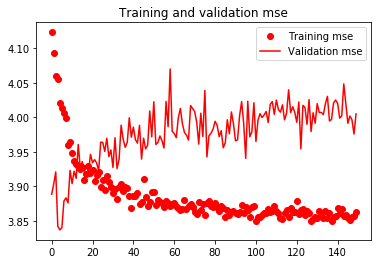

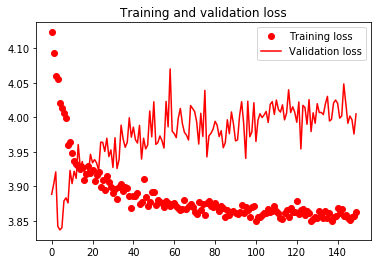

In [29]:
# accuracy = model_train.history['acc']
# val_accuracy = model_train.history['val_acc']
# loss = model_train.history['loss']
# val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training mse',c='red')
plt.plot(epochs, val_accuracy, 'b', label='Validation mse',c='red')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss',c='red')
plt.plot(epochs, val_loss, 'b', label='Validation loss',c='red')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [30]:
predicted_classes = model.predict([test_X_cell,test_X_drug])

In [31]:
predicted_value = predicted_classes

In [32]:
# saving predicted ln(IC50)s and ln(IC50)s in the test set
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_label_array)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]
c.to_csv(workdir + '//200915_EYDC9K_CNN_pred_and_val_result.csv', index=False)


In [33]:
# result table
c.head()

,Predicted,Test
0,1.451017,-4.667942
1,0.768922,2.079442
2,0.446029,2.079442
3,1.135387,2.079442
4,0.892796,2.079442


In [34]:
predicted_value.shape

(959, 1)

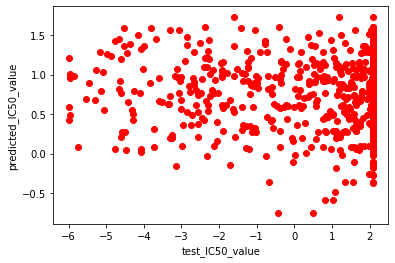

In [35]:
# scatter plot
plt.scatter(test_label_array,predicted_value,c='red')
plt.xlabel('test_IC50_value')
plt.ylabel('predicted_IC50_value')
plt.savefig(workdir + '//EYDC9K_CNN_test_scatterplot.png')

In [36]:
# R-squared value
from sklearn.metrics import r2_score
r2_value = r2_score(b,a)
print(r2_value)

-0.028573571811577603


In [37]:
# Linear regression value (slope)
from scipy.stats import linregress
linregress(b[0], a[0])

LinregressResult(slope=0.010230939329059182, intercept=0.8053228808876592, rvalue=0.04728377997949736, pvalue=0.14341818704222384, stderr=0.006986526662907003)

In [38]:
# RMSE
rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

Final rmse value is = 2.0011886548969513
